# Exploring the MNIST Digits Dataset

## Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

## Exploring Data

In [2]:
# check shape of the data

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


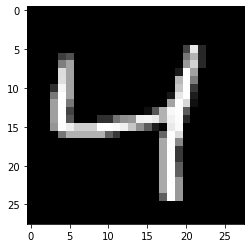

correct number: 4


In [3]:
# visualize single data instances

img_no = 2 #change the number to display other examples

first_number = x_train[img_no]
plt.imshow(first_number, cmap='gray') # visualize the numbers in gray mode
plt.show()
print(f"correct number: {y_train[img_no]}")

## Preparing Data & Splitting

In [4]:
# reshaping the data
# reshaping pixels in a 28x28px image with greyscale, canal = 1. This is needed for the Keras API
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# normalizing the data
# each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
x_train = x_train / 255
x_test = x_test / 255

print(f"train X shape: {x_train.shape}")
print(f"test X shape: {x_test.shape}")

train X shape: (60000, 28, 28, 1)
test X shape: (10000, 28, 28, 1)


In [5]:
# new functions

## Model Building

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax')) #output are 10 classes, numbers from 0-9

#show model summary - how it looks
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [7]:
#compile the model - we want to have a multiple outcome
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [8]:
#fit the model and return the history while training
history = model.fit(
  x=x_train,
  y=y_train,
  epochs=1
)

1875/1875 [==============================] - 114s 61ms/step - loss: 0.2483 - accuracy: 0.9230


## Model Evaluation

In [9]:
keras.models.save_model(model,"models/detect-digits")

INFO:tensorflow:Assets written to: models/detect-digits/assets


In [10]:
from minio import Minio
import os

minio_client = Minio(
        "100.65.11.110:9000",
        access_key="minio",
        secret_key="minio123",
        secure=False
    )
minio_bucket = "mlpipeline"


import glob

def upload_local_directory_to_minio(local_path, bucket_name, minio_path):
    assert os.path.isdir(local_path)

    for local_file in glob.glob(local_path + '/**'):
        local_file = local_file.replace(os.sep, "/") # Replace \ with / on Windows
        if not os.path.isfile(local_file):
            upload_local_directory_to_minio(
                local_file, bucket_name, minio_path + "/" + os.path.basename(local_file))
        else:
            remote_path = os.path.join(
                minio_path, local_file[1 + len(local_path):])
            remote_path = remote_path.replace(
                os.sep, "/")  # Replace \ with / on Windows
            minio_client.fput_object(bucket_name, remote_path, local_file)
            
upload_local_directory_to_minio("models/detect-digits",minio_bucket,"/models/detect-digits")

MaxRetryError: HTTPConnectionPool(host='100.65.11.110', port=9000): Max retries exceeded with url: /mlpipeline?location= (Caused by ResponseError('too many 503 error responses'))

In [ ]:
#load model if already trained
model = keras.models.load_model("detect-digits.h5")
#keras.models.save_model(model,"detect-digits.h5")

In [ ]:
# Test the model against the test dataset
# Returns the loss value & metrics values for the model in test mode.
model_loss, model_accuracy = model.evaluate(x=x_test,y=y_test)

In [ ]:
# Confusion Matrix

# Generates output predictions for the input samples.
test_predictions = model.predict(x=x_test)

# Returns the indices of the maximum values along an axis.
test_predictions = np.argmax(test_predictions,axis=1) # the prediction outputs 10 values, we take the index number of the highest value, which is the prediction of the model

# generate confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=y_test,predictions=test_predictions)

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
h = sns.heatmap(confusion_matrix,annot=True,fmt='d')
h.set(xlabel='Predicted', ylabel='Actual')